[VAE](https://en.wikipedia.org/wiki/Variational_autoencoder)

[Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

## GP 1D Data Generator

In [ ]:
#import os,sys
#sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
import numpy as np  
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class GP1D(Dataset):
    def __init__(self, dataPoints=100, samples=10000, ingrid=True, x_lim = 1,
                        seed=np.random.randint(20), kernel='rbf',ls = 0.1, nu=2.5):
        self.dataPoints = dataPoints
        self.samples = samples
        self.ingrid = ingrid
        self.x_lim = x_lim
        self.seed = seed
        self.Max_Points = 2 * dataPoints
        self.ls = ls
        self.nu = nu
        self.kernel = kernel
        np.random.seed(self.seed)
        self.evalPoints, self.data = self.__simulatedata__()
    
    def __len__(self):
        return self.samples
    
    def __getitem__(self, idx=0):
        return(self.evalPoints[:,idx], self.data[:,idx])


    def __simulatedata__(self):
        if self.kernel=='rbf':
            gp = GaussianProcessRegressor(kernel=RBF(length_scale=self.ls))
        elif self.kernel=='matern':
            gp = GaussianProcessRegressor(kernel=Matern(length_scale=self.ls, nu=self.nu))
        else:
            return None
        if (self.ingrid):
            X_ = np.linspace(-self.x_lim, self.x_lim, self.dataPoints)
            y_samples = gp.sample_y(X_[:, np.newaxis], self.samples)
            # print(X_.shape, y_samples.shape)
            return (X_.repeat(self.samples).reshape(X_.shape[0],self.samples) ,
                        y_samples)
        else:
            X_ = np.linspace(-self.x_lim, self.x_lim, self.Max_Points)
            X_ = np.random.choice(X_, (self.dataPoints,self.samples))
            X_.sort(axis=0)
            y_samples = np.zeros((self.dataPoints,self.samples))
            for idx in range(self.samples):
                x_ = X_[:,idx]
                y_samples[:,idx] = gp.sample_y(x_[:, np.newaxis]).reshape(self.dataPoints,)
            # print(X_.shape, y_samples.shape)
            return (X_, y_samples)

___

## VAE = Encoder + Decoder

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.distributions import Normal

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.mu = nn.Linear(hidden2_dim, z_dim)
        self.std = nn.Linear(hidden2_dim, z_dim)

    def forward(self, x):
        hidden1 = torch.tanh(self.linear1(x))
        hidden2 = torch.tanh_(self.linear2(hidden1))
        z_mu = self.mu(hidden2)
        z_std = self.std(hidden2)

        return z_mu, z_std

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden1_dim, hidden2_dim, input_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(z_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.out = nn.Linear(hidden2_dim, input_dim)

    def forward(self, z):
        hidden1 = torch.tanh(self.linear1(z))
        hidden2 = torch.tanh(self.linear2(hidden1))
        pred = self.out(hidden2)

        return pred

torch.randn_like(input, *, dtype=None, layout=None, device=None, requires_grad=False, memory_format=torch.preserve_format) 

Returns a tensor with the same size as input filled with random numbers from a normal **distribution with mean 0 and variance 1**

torch.randn_like(input) is equivalent to torch.randn(input.size(), dtype=input.dtype, layout=input.layout, device=input.device).

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.encoder = Encoder(input_dim, hidden1_dim, hidden2_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden1_dim, hidden2_dim, input_dim)

    def reparameterize(self, z_mu, z_std):
        if self.training:
            sd = torch.exp(z_std / 2)
            #eps = torch.randn_like(sd)
            eps = Normal(0.0, 0.1).sample(sd.size())
            return eps.mul(sd).add_(z_mu)
            #return Normal(z_mu, sd).sample()
        else:
            return z_mu

    def forward(self, x):
        z_mu, z_std = self.encoder(x)
        z_sample = self.reparameterize(z_mu, z_std)
        pred = self.decoder(z_sample)
        return pred, z_mu, z_std

___

## Loss Function

In [ ]:
def compute_loss(x, x_pred, mean, log_sd):
    RCL = F.mse_loss(x_pred, x, reduction='sum')
    KLD = -0.5*torch.sum(1+log_sd - mean.pow(2) - log_sd.exp())
    return RCL + KLD

___

In [ ]:
   ###### intializing data and model parameters
input_dim = 100
batch_size = 500    
hidden_dim1 = 64
hidden_dim2 = 32
z_dim = 20
samples = 100000

In [ ]:
###### creating data, model and optimizer
train_ds = GP1D(dataPoints=input_dim, samples=samples, ls=0.1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [ ]:
len(train_ds)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for no, dt in enumerate(train_dl):
        ax.plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), marker='o', markersize=3)
        if no > 9: break
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('10 different function realizations at fixed 100 points\n'
    'sampled from a Gaussian process with RBF')

___

In [ ]:
import torch.optim as optim 

In [ ]:
model = VAE(input_dim, hidden_dim1, hidden_dim2, z_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

## Training

In [ ]:
from tqdm import tqdm, trange

In [ ]:
t = trange(100)
for e in t:
    model.train()
    total_loss = 0
    for i, x in enumerate(train_dl):
        x = x[1].float().to(device)
        optimizer.zero_grad()
        x_pred, z_mu, z_sd = model(x)
        loss = compute_loss(x, x_pred, z_mu, z_sd)
        loss.backward()

        total_loss += loss.item()

        optimizer.step()
    t.set_description(f'Loss is {total_loss/(samples*input_dim):.3}')

## Eval

In [ ]:
model.eval()
z = torch.randn(5, z_dim).to(device)

with torch.no_grad():
    x_sample = model.decoder(z)

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for no, y in enumerate(x_sample):
    ax.plot(train_ds.evalPoints[:,0], y.cpu().numpy(), marker='o', markersize=3)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('5 different function realizations at fixed 100 points\n'
    'sampled from a VAE learned with prior as GP (RBF)')
    #plt.savefig('plots/sample_prior_vae_1d_fixed.pdf')

## Inference

In [ ]:
observed = GP1D(input_dim, 1, ls=0.1)

In [ ]:
observed[0][1]

In [ ]:
model = model.to('cpu')

In [ ]:
decoder_dict = model.decoder.state_dict()

In [ ]:
decoder_dict

In [ ]:
f = observed[0][1]

In [ ]:
decoder_dict['linear1.bias'].T

In [ ]:
y = f + np.random.randn(input_dim) * 0.1

In [ ]:
stan_data = {
    "p": z_dim,
    "p1": hidden_dim1,
    "p2": hidden_dim2,
    'n': input_dim,
    "W1": decoder_dict['linear1.weight'].T.numpy(),
    'B1': decoder_dict['linear1.bias'].T.numpy(),
    'W2': decoder_dict['linear2.weight'].T.numpy(),
    "B2": decoder_dict['linear2.bias'].T.numpy(),
    "W3": decoder_dict['out.weight'].T.numpy(),
    "B3": decoder_dict['out.bias'].T.numpy(),
    'y': y
}

## Stan

In [ ]:
import cmdstanpy

In [ ]:
cmdstanpy.install_cmdstan()

In [35]:
sm = cmdstanpy.CmdStanModel(stan_file='stan_1D.stan')

13:25:38 - cmdstanpy - INFO - compiling stan file /home/dulunche/GP_VAE/drclab/VAE/stan_1D.stan to exe file /home/dulunche/GP_VAE/drclab/VAE/stan_1D
13:26:07 - cmdstanpy - INFO - compiled model executable: /home/dulunche/GP_VAE/drclab/VAE/stan_1D


In [36]:
fit = sm.sample(data= stan_data, iter_sampling=2000, iter_warmup=500, chains=4)

13:26:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:26:11 - cmdstanpy - INFO - CmdStan done processing.


In [37]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,131.239000,0.066398,3.540410,124.847000,131.588000,136.395000,2843.09,550.56,1.002580
z[1],-0.221073,0.000712,0.063004,-0.325460,-0.221112,-0.118084,7840.23,1518.25,0.999812
z[2],0.374505,0.000561,0.054096,0.285614,0.374496,0.462876,9305.87,1802.07,1.000160
z[3],1.034760,0.000619,0.046722,0.958176,1.034780,1.110490,5705.96,1104.95,0.999828
z[4],0.197644,0.000596,0.048395,0.118257,0.198180,0.276529,6603.66,1278.79,1.000260
...,...,...,...,...,...,...,...,...,...
y2[96],2.123550,0.001821,0.168408,1.842300,2.123170,2.401510,8550.88,1655.86,0.999657
y2[97],2.199440,0.001866,0.167609,1.920690,2.198340,2.471490,8065.93,1561.95,0.999952
y2[98],2.235630,0.001893,0.170848,1.960130,2.232740,2.514590,8141.70,1576.63,1.000700
y2[99],2.217650,0.001924,0.180153,1.923900,2.216810,2.517170,8769.83,1698.26,1.000380


In [38]:
out = fit.stan_variables()

In [39]:
fit.diagnose()

'Processing csv files: /tmp/tmpklzub4lb/stan_1Driqea7hr/stan_1D-20221106132609_1.csv, /tmp/tmpklzub4lb/stan_1Driqea7hr/stan_1D-20221106132609_2.csv, /tmp/tmpklzub4lb/stan_1Driqea7hr/stan_1D-20221106132609_3.csv, /tmp/tmpklzub4lb/stan_1Driqea7hr/stan_1D-20221106132609_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [40]:
out

{'z': array([[-0.157401 ,  0.299885 ,  1.0333   , ..., -1.55197  , -0.362489 ,
          0.0369037],
        [-0.243305 ,  0.429479 ,  0.979708 , ..., -0.566877 , -0.340636 ,
          0.0560788],
        [-0.1889   ,  0.308931 ,  1.06469  , ..., -0.184271 , -0.358634 ,
          0.0404953],
        ...,
        [-0.231697 ,  0.4037   ,  0.984021 , ..., -0.0604532, -0.28946  ,
          0.0266983],
        [-0.250013 ,  0.36153  ,  1.00088  , ...,  0.0801642, -0.299274 ,
          0.102509 ],
        [-0.254971 ,  0.388295 ,  1.07017  , ...,  1.37812  , -0.434813 ,
          0.0507209]]),
 'sigma2': array([0.177481, 0.141315, 0.154658, ..., 0.1512  , 0.16303 , 0.156341]),
 'f': array([[0.928317, 0.893118, 0.848517, ..., 2.15951 , 2.11981 , 2.02171 ],
        [0.793106, 0.776462, 0.748239, ..., 2.27942 , 2.27462 , 2.20464 ],
        [0.748101, 0.715162, 0.676163, ..., 2.21064 , 2.18483 , 2.09873 ],
        ...,
        [0.845433, 0.842189, 0.823067, ..., 2.32687 , 2.3082  , 2.22839 ],
 

In [41]:
fit.save

AttributeError: Unknown variable name: save
Available variables are z, sigma2, f, y2

## Posterior Plotting

In [42]:
import arviz as az

/home/dulunche/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/dulunche/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


array([[<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>]], dtype=object)

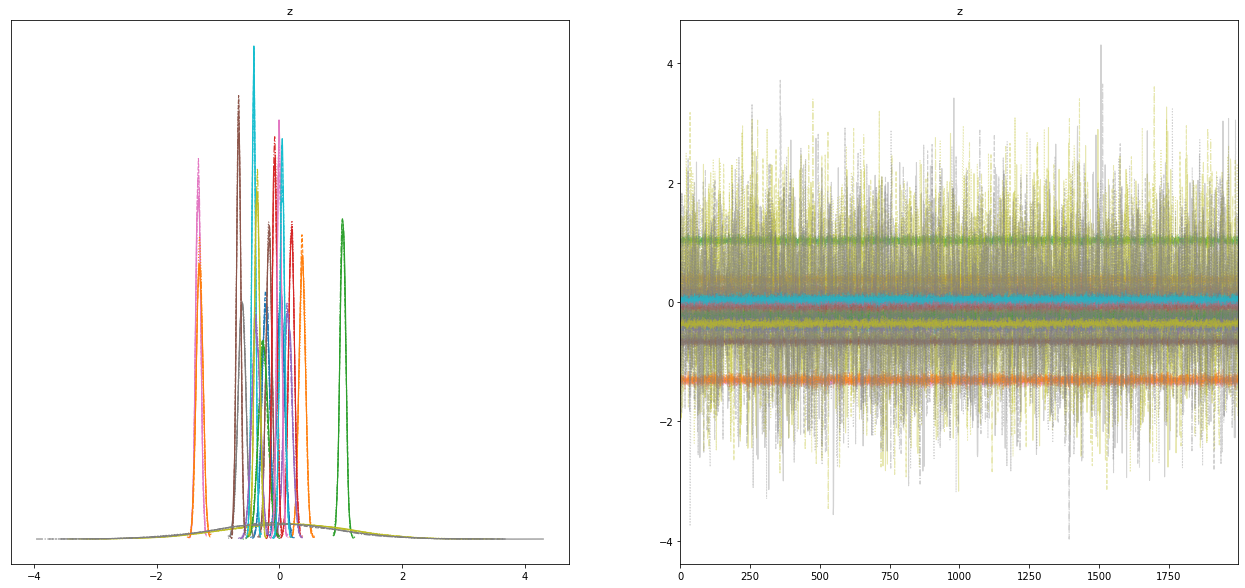

In [43]:
az.plot_trace(fit, var_names=["z"], figsize=(22,10))

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

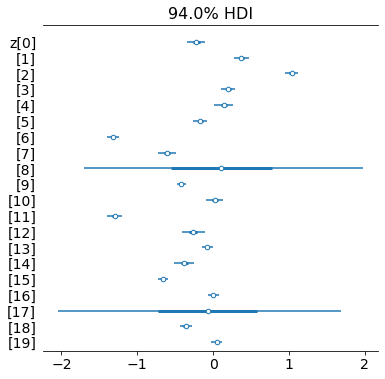

In [44]:
az.plot_forest(fit, var_names="z", combined=True)

In [45]:
import pandas as pd

In [46]:
datapoints = observed[0][0]
df = pd.DataFrame(out['y2'])

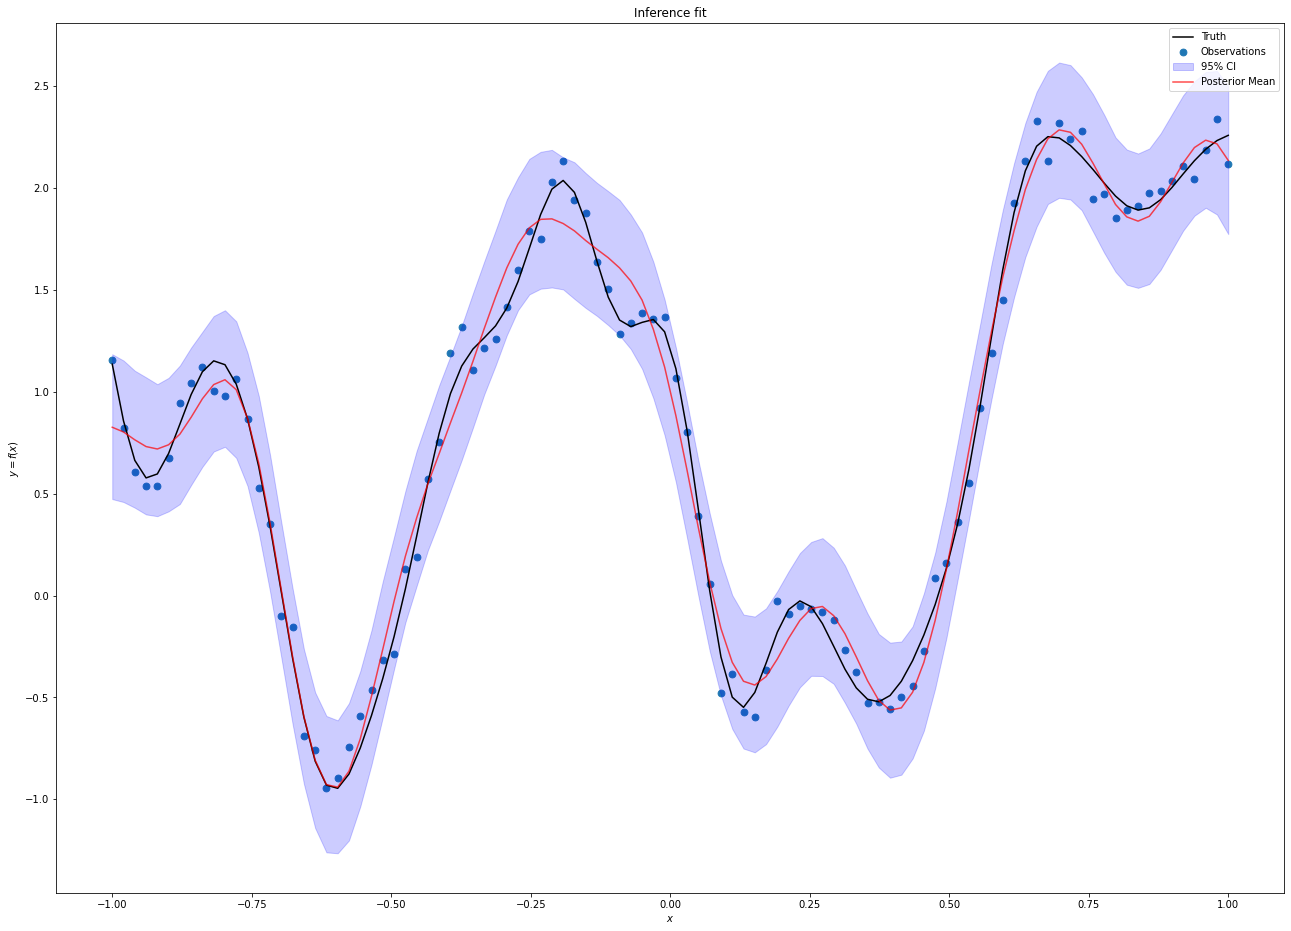

In [47]:
fig = plt.figure(figsize=(22,16))
ax = fig.add_subplot(111)
ax.plot(datapoints, f.reshape(-1,1), color="black", label="Truth")
ax.scatter(datapoints, y.reshape(-1,1), s=46, label="Observations")
ax.fill_between(datapoints, 
                df.quantile(0.025).to_numpy(), 
                df.quantile(0.975).to_numpy(),
                #facecolor = "blue",
                color="blue",
                alpha= 0.2,
                label = "95% CI"
)
ax.plot(datapoints, df.mean().to_numpy().reshape(-1,1), color="red", alpha=0.7,
    label="Posterior Mean"
)
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Inference fit')
ax.legend()
